<div class="alert alert-block alert-info">


<h1 align="left">NBA Fantasy Point Predictor</h1> 

<img align="right" src="nba-logo.jpg" width="200" height="200"/>

<h3 align="center">Predicting the FanDuel scoring of NBA players through machine learning</h3> 
<h3 align="center">Cobi O'Connell</h3> 
<br> <br> <br> <br> <br>

</div>


<img src="FanDuel.png" width="200" height="200"/>



<br> <br>

<h2 align="center">Introduction</h2> <br>

- I am very passionate about both sports and fantasy sports. For those who do not know, fantasy sports consists of building lineups of players where your success is determined by the number of points that your team scores, which correlates directly to player performance in real life.


- In recent years, there has been an emergence of DFS (Daily Fantasy Sports) where users can build fantasy lineups for just a certain day, with the opportunity to place and win money if the lineup suceeds. 


- Since I am big on betting on DFS (I currently run a website with that being the main focus), I figured building a model to project NBA fantasy scores for players would be both fun and useful to me. 


<br> <br>

<div class="alert alert-block alert-info">
    
<h2 align="center">FanDuel</h2> <br> <br>

<br>
<img align="right" src="lineup.png" width="200" height="200"/>
<h4 align="center"><i>FanDuel is a site that provides users the opportunity to build lineups and compete against eachother to earn money. This model is optimized to run on FanDuel, since that is what I play.<i></h4>

<br> <br>

- FanDuel Rules:
    1. Each lineup must consist of 9 total players. 
    2. Of the 9 players, the lineup must include 2 Point Guards, 2 Shooting Guards, 2 Small Forwards, 2 Power Forwards, and 1 Center. 
    3. The total sum of the players’ salaries cannot exceed 60,000.
    4. You are limited to a maximum of 4 players from a single NBA team. 

    
- FanDuel points scoring: <br>
    - 1 point = 1 FD point
    - 1 assist = 1.5 FD points
    - 1 rebound = 1.2 FD points
    - 1 block or steal = 3 FD points
    - 1 turnover = -1 FD point
 <br>

</div>




<br> <br>

<h2 align="center">Data Collection</h2> <br>

- Nearly all of the data used in the training, testing, and projecting in this model is accessed through various endpoints of Swar's NBA API, which interacts directly with NBA.com.


- Link to the API - https://github.com/swar/nba_api


- Link to NBA.com - https://www.nba.com/stats/

<br> <br>

<div class="alert alert-block alert-success">
    
<h2 align="center">The Model</h2> <br> <br>

- This model will start at the first week of the NBA season, train on that week, and then test on the following day. Next, it will shift the window to the first two weeks, train, then test on the following day. It will continue to iterate on that schedule until it reaches the current date.



- The machine learning algorithm being used is multiple regression with 8 different variables. That will be discussed more further on.


- It compares the advanced model against both a random model, and a model that predicts the players' average within the training range, by looking at the $R^2$ of both the training and the testing, and the Root Means Squared Error of the testing.


- $R^2$ indicates how much variation of the variation in fantasy points scored is explained by the independent variables, and Root Means Squared Error calculates the standard deviation of the error between the prediction and the actual points scored for testing.

</div>


In [ ]:
import datetime
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nba_api
import random
import time
import math
import sys
import requests
from datetime import datetime, timedelta, date
from ortools.linear_solver import pywraplp
from nba_api.stats.static import players
from nba_api.stats.endpoints import (commonallplayers, commonplayerinfo, playergamelogs, playergamelog, 
boxscoresummaryv2, gamerotation, leaguegamefinder, fantasywidget, teamgamelogs, scoreboard, teamplayerdashboard, 
                                     playerdashboardbylastngames, playerfantasyprofile, leaguedashlineups, teamgamelogs, playerestimatedmetrics, 
                                    playerdashboardbygamesplits, leaguedashplayerbiostats, boxscoresummaryv2, scoreboardv2, boxscoretraditionalv2)

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


<br> <br>

<div class="alert alert-block alert-info">
  

- This cell simply loads the file that is used to give the data to project a player's fantasy scoring for today.


- The file includes the names of all the players that are playing today, their position, their salary on FanDuel, and all of their stats that are used as variables for projections by multiplying against the thetas of the training. Usage, and their last $n$ game averages are calculated from the NBA API later on.


- Link to the site with the file - https://www.lineups.com/nba/nba-fantasy-basketball-projections
<div>

In [ ]:


#get players name, salary, and fanduel fantasy points per minute
def getPlayerInfo(todays_file):
    player_data = pd.read_csv(todays_file)
    player_info = pd.read_csv(todays_file, usecols=['Name', 'Pos', 'Salary', 'FPPM', 'Minutes', 'DVP', 'O/U', 'Spread'])
    return player_info
 

<br> <br>

<div class="alert alert-block alert-success">
    

- The only purpose of the two functions in the cell below is to get the game IDs, the player IDs, and the names of the players that are playing today from the API.

</div>

In [ ]:
def getGamesToday():
    #get current date
    currentDT = datetime.now()
    currentDT = currentDT.strftime("%Y-%m-%d")
    #games happening on current date
    games = scoreboard.Scoreboard(game_date = currentDT).get_data_frames()[0]
    game_IDs = []

    #get all the IDs of the teams playing today
    for i in games.loc[:, "HOME_TEAM_ID"]:
        game_IDs.append(i)
    for ii in games.loc[:, "VISITOR_TEAM_ID"]:
        game_IDs.append(ii)
        
    #remove duplicates (not sure why there were some duplicates)
    final_game_IDs = []
    [final_game_IDs.append(x) for x in game_IDs if x not in final_game_IDs]
    
    return final_game_IDs

    
    
def getPlayersToday(final_game_IDs):
    #get the player id and names of everyone on the roster of a team playing today (injuries are included)
    players_IDs_today = []
    players_names_today = []
    for x in final_game_IDs:
        teams_roster = teamplayerdashboard.TeamPlayerDashboard(team_id=x).get_data_frames()[1]
        time.sleep(random.gammavariate(alpha=9, beta=0.4))
        for p_ID in teams_roster['PLAYER_ID']:
            players_IDs_today.append(p_ID)
        for p_name in teams_roster['PLAYER_NAME']:
            players_names_today.append(p_name)
            
    return players_IDs_today, players_names_today
    




<br> <br>

<div class="alert alert-block alert-info">

- The first function in the cell below will create a dictionary of all the players who are playing today with their name as the key, and their projected minutes as the value.


- The second function will take the projected points of each player given by the training model later on, and will calculate the value of the player in relation to their salary on FanDuel and their projected points. 


- The final function creates an export sheet that provides useful information about the projections in the form of an excel sheet. This would be excellent for any user who just wants to see how well a player might do today, and isn't curious about the back-end. 


- The image below shows the first page of the sheet for May 10th, 2021. It is first sorted by position, then by projected points. 



<img src="valuesheet.png"/>
<div>

In [ ]:
#make a dict with player name as key and their projected minutes as value
def setProjectedMinutes(players_names_today, player_info):
    player_proj_minutes = {}
    for name in players_names_today: 
        player_index = player_info.index[player_info["Name"] == name]
        if player_index.size > 0 : 
            proj_min = int(player_info['Minutes'][player_index])
            player_proj_minutes[name] = proj_min
            
    return player_proj_minutes

    

#get the value of the player based on projected points relative to salary on Fanduel
def getValue(player_proj_pts, player_info):
    player_proj_value = {}
    for name in player_proj_pts: 
        player_index = player_info.index[player_info["Name"] == name]
        if player_index.size > 0 : 
            salary = float(player_info['Salary'][player_index])
        else: 
            salary = 100000
        value = float(np.round(player_proj_pts[name]/salary*1000, decimals = 2))
        player_proj_value[name] = value
       
    return player_proj_value


#export an excel sheet with information on the player's projected points, value, etc
def exportValueSheet(value, player_proj_min, player_proj_pts, player_info):
    count = 0
    for player in value: 
        player_index = player_info.index[player_info["Name"] == player]
        if player_index.size > 0 : 
            salary = float(player_info['Salary'][player_index])
            position = player_info['Pos'].values[player_index]
            if count == 0:
                value_sheet = np.array([[player, position[0], salary, player_proj_min[player], player_proj_pts[player], value[player]]], dtype=object)
                count += 1
            else: 
                temp_arr = np.array([player, position[0], salary, player_proj_min[player], player_proj_pts[player], value[player]], dtype=object)
                value_sheet = np.vstack((value_sheet, temp_arr))
        else: 
            #if player doesn't have salary, either hurt or inactive for game
            player_proj_min[player] = 0
        
            
    df = pd.DataFrame(value_sheet)
    currentDT = datetime.now()
    currentDT = currentDT.strftime("%Y-%m-%d")
    sorted_df = df.sort_values([1,4], ascending = [True,False], axis = 0)
    header_list = ['Name', 'Position', 'Salary', 'Projected Minutes', 'Projected Points', 'Value']
    sorted_df.to_csv(currentDT + '-NBA-value.csv', header=header_list)
    


    


<br> <br>

<div class="alert alert-block alert-success">
    

- This cell is no longer being used in the model. At the basic stages of this project, it served to project all the player's minutes based on their last three games, and to project their points by multiplying that projected number by their fantasy points per minute. 

</div>

In [ ]:
#based on last three games (no longer used - just using their projected min now)
def projectMinutes(players_IDs_today, players_names_today):
    count = 0 
    player_proj_minutes = {}
    
    all_logs = playergamelogs.PlayerGameLogs(season_nullable = '2020-21')
    df = all_logs.player_game_logs.get_data_frame()
    ## convert GAME_ID column from str to int
    df['GAME_ID'] = df['GAME_ID'].astype('int')
    ## get GAME_ID last 3 games for all player, who played in season
    last_3_games = df.groupby('PLAYER_ID')['GAME_ID'].nlargest(3).reset_index().drop(columns = 'level_1')
    df = df.merge(last_3_games, how = 'inner', on = ['PLAYER_ID', 'GAME_ID'], validate = '1:1')
    
    for player_ID in players_IDs_today:
        curr_player = df.loc[df['PLAYER_ID'] == player_ID]
        proj_min = np.round(np.sum(curr_player.loc[:,'MIN']/3), decimals = 2)      
        #calculate projected mintues based on average minutes played in last three games from game logs
        name = players_names_today[count]
    
        player_proj_minutes[name] = proj_min
        count += 1
 
    return player_proj_minutes


# the simple model (no longer used)
def projectPoints(player_proj_min, player_info):
    player_proj_pts = {}
    for name in player_proj_min:
        #get their index in list from first cell to find fantasy points per minute
        #if not in player_info, the player is in G-League and isn't playing today
        player_index = player_info.index[player_info["Name"] == name]
        if player_index.size > 0 : 
            fppm = float(player_info['FPPM'][player_index])
        else: 
            fppm = 0
        #project points based on projected minutes * fanduel points per minute
        proj_pts = np.round(player_proj_min[name] * fppm, decimals=2)
        #set projected points equal to players name key
        player_proj_pts[name] = proj_pts
       
        
    return player_proj_pts

<br> <br>

<div class="alert alert-block alert-info">

- The following cell contains a lot of the data collection for the variables of the training and testing of the model by accessing various endpoints of the NBA API. 


- It includes gathering game logs with lots of information for each player in each game on the season, getting team logs, usage, fantasy points per minute, the implied total (total points scored by both teams), the spread (difference in points scored between both teams), the fantasy points scored in their last game, and their average fantasy points scored in their last 3 and 5 games. 

<div>

In [ ]:
def getPlayerGameLogs():
    all_logs = playergamelogs.PlayerGameLogs(season_nullable = '2020-21')
    df = all_logs.player_game_logs.get_data_frame()
    
    return df, df['MIN'], df['NBA_FANTASY_PTS'], df[['PLAYER_NAME','MIN']], df['PLAYER_NAME'], df["TEAM_ID"], df["GAME_ID"]


def getTeamGameLogs():
    all_logs = teamgamelogs.TeamGameLogs(season_nullable = '2020-21')
    df = all_logs.team_game_logs.get_data_frame()
    ## convert GAME_ID column from str to int
    df['GAME_ID'] = df['GAME_ID'].astype('int')
    return df
    
    
    
#get players usage
def getPlayerUsage():
    player_usage = playerestimatedmetrics.PlayerEstimatedMetrics().get_data_frames()[0]
    player_usage = player_usage[['PLAYER_NAME','E_USG_PCT']]
    usage_map = {player_usage['PLAYER_NAME'][idx] : player_usage['E_USG_PCT'][idx] for idx in range(len(player_usage))} 
    return usage_map



#get a player's FPPM (fantasy points per minute)
def getPlayerFPPM():
    fppm_map = {}
    player_dict = commonallplayers.CommonAllPlayers().get_data_frames()[0]
    all_logs = playergamelogs.PlayerGameLogs(season_nullable = '2020-21')
    df = all_logs.player_game_logs.get_data_frame()
    
    for name in player_dict['DISPLAY_FIRST_LAST']:
        #find current player in game logs
        curr_player = df.loc[df['PLAYER_NAME'] == name]
        minutes = np.sum(curr_player.loc[:, 'MIN'])
        if minutes == 0:
            fppm = 0
        else: 
            fppm =  np.round(np.sum(curr_player.loc[:, 'NBA_FANTASY_PTS'])/np.sum(curr_player.loc[:, 'MIN']), decimals = 2)
        fppm_map[name] = fppm
        
    return fppm_map



#get the total points scored by both teams in a game
def getTeamTotalsSpread(game_IDs):
    train_total_vector = []  
    train_spread_vector = []
    all_logs = teamgamelogs.TeamGameLogs(season_nullable = '2020-21')
    df = all_logs.team_game_logs.get_data_frame()
    
    #iterate through each game id and find total points scored
    for ids in game_IDs:
        curr_game = df.loc[df['GAME_ID'] == ids]
        total_scored = np.sum(curr_game.loc[:, 'PTS'])
        train_total_vector.append(total_scored)
        spread = list(curr_game.loc[:, 'PLUS_MINUS'])
        spread = abs(spread[0])
        train_spread_vector.append(spread)
     
    return train_total_vector, train_spread_vector



#find the implied team totals for games today to use in predicitons
def getImpliedTeamTotals(player_info):
        implied_total_map = {}
        for name in player_info["Name"]:
            player_index = player_info.index[player_info["Name"] == name]
            total = float(player_info['O/U'][player_index])
            implied_total_map[name] = total
            
        return implied_total_map
    
    
#find the spread for games today to use in predicitons
def getGameSpread(player_info):
        spread_map = {}
        for name in player_info["Name"]:
            player_index = player_info.index[player_info["Name"] == name]
            spread = float(player_info['Spread'][player_index])
            spread_map[name] = spread
            
        return spread_map

    
#get player's most recent, last 3, and last 5 scoring averages
def getRecentPerformances(game_log, names):
    last_game = []
    last_3_games = []
    last_5_games = []
    df = game_log.copy()
    df2 = game_log.copy()
    df3 = game_log.copy()
    
    #used to get player's average for last game only
    df['GAME_ID'] = df['GAME_ID'].astype('int')
    ## get GAME_ID last game for all players, who played in season
    last_games = df.groupby('PLAYER_ID')['GAME_ID'].nlargest(1).reset_index().drop(columns = 'level_1')
    df = df.merge(last_games, how = 'inner', on = ['PLAYER_ID', 'GAME_ID'], validate = '1:1')
    
    #used to get player's average for last 3 games only
    df2['GAME_ID'] = df2['GAME_ID'].astype('int')
    ## get GAME_ID last 3 games for all player, who played in season
    last_3_game = df2.groupby('PLAYER_ID')['GAME_ID'].nlargest(3).reset_index().drop(columns = 'level_1')
    df2 = df2.merge(last_3_game, how = 'inner', on = ['PLAYER_ID', 'GAME_ID'], validate = '1:1')
    
    #used to get player's average for last 5 games only
    df3['GAME_ID'] = df3['GAME_ID'].astype('int')
    ## get GAME_ID last 5 games for all player, who played in season
    last_5_game = df3.groupby('PLAYER_ID')['GAME_ID'].nlargest(5).reset_index().drop(columns = 'level_1')
    df3 = df3.merge(last_5_game, how = 'inner', on = ['PLAYER_ID', 'GAME_ID'], validate = '1:1')
    
    
    for name in names:
        #find current player in game logs
        curr_player = df.loc[df['PLAYER_NAME'] == name]
        curr_player2 = df2.loc[df2['PLAYER_NAME'] == name]
        curr_player3 = df3.loc[df3['PLAYER_NAME'] == name]
        avg_score = np.round(np.sum(curr_player.loc[:, 'NBA_FANTASY_PTS']), decimals = 2)
        avg_score2 = np.round(np.sum(curr_player2.loc[:, 'NBA_FANTASY_PTS'])/3, decimals = 2)
        avg_score3 = np.round(np.sum(curr_player3.loc[:, 'NBA_FANTASY_PTS'])/5, decimals = 2)
        last_game.append(avg_score)
        last_3_games.append(avg_score2)
        last_5_games.append(avg_score3)
        
    return last_game, last_3_games, last_5_games
    
    

<br> <br>

<div class="alert alert-block alert-success">
    

- The following cell contains the random model, the average model, and the multiple linear regression model, as well as a function to compare them. It also contains the function to make projections based on the thetas gathered from training and today's data, as well as the root means squared error calculation.


- The random model will project a random value between 0 and 60 for each player. 


- The average model will project each player's season average fantasy points scored up to the testing date.


- The linear regression model gets inputted the X and y training values, as well as the X and y testing values, which is gathered from all games within the specific training/test range. From that data, it can generate the theta values to best fit the model.


- Each model will give an $R^2$ value and a Root Means Squared Error value for its predictions. 


</div>

In [ ]:


def compareModels(X_train, y_train, X_test, y_test, test_names, game_logs):

    #model with random predicted values 0 through 60
    random_model = randomModel(y_test)
    
    #model where predicted is their season average fantasy points
    simple_model = averageModel(y_test, test_names, game_logs)
    
    
    #advanced model currently being built up
    linear_regression = linearRegression(X_train, X_test, y_train, y_test)

    
    return linear_regression



def randomModel(y_test):
    
    #model that predicts a random value from 0-60 for testing against
    random_predictions = np.random.randint(0,60, size=y_test.size)
    
    # Comparing r2 
    print("Random Model Test R2: " + str(r2_score(y_test,random_predictions)))
    
    #root means squared error
    random_rmse = rootMeanSquaredError(random_predictions, y_test)
    print("Random Model RMSE: " + str(random_rmse))
    
    return random_predictions
    
    
    
    
    

    
def averageModel(y_test, test_names, game_logs):
    predicted_points = []
    for name in test_names:
        #find current player in game logs
        curr_player = game_logs.loc[game_logs['PLAYER_NAME'] == name]
        #get games played on season
        gp = len(game_logs[game_logs['PLAYER_NAME'] == name])
        #calculate average score by summing and diving by games played
        if (gp == 0):
            avg_score = 0
        else:
            avg_score = np.round(np.sum(curr_player.loc[:, 'NBA_FANTASY_PTS'])/gp, decimals = 2)
        predicted_points.append(avg_score)
    
        
    # Comparing r2 
    print("\n")
    print("Baseline Model Test R2: " + str(r2_score(y_test,predicted_points)))
    
    
    #root means squared error
    base_rmse = rootMeanSquaredError(predicted_points, y_test)
    print("Baseline Model RMSE: " + str(base_rmse))
     
        
        


def linearRegression(X_train_lm, X_test_lm, y_train_lm, y_test_lm):
    linear_model = LinearRegression()
    

    # Fit the model
    linear_model.fit(X_train_lm, y_train_lm)


    # Making Predictions of y
    y_train_predicted = linear_model.predict(X_train_lm)
    y_test_predicted = linear_model.predict(X_test_lm)

    # Comparing r2 of training and test
    print("\n")
    print("LR Train R2: " + str(r2_score(y_train_lm,y_train_predicted)))
    print("LR Test R2: " + str(r2_score(y_test_lm,y_test_predicted)))
    print("LR Adjusted Train R2: " + str(1-(1-r2_score(y_train_lm, y_train_predicted))*((len(X_train_lm)-1)/(len(X_train_lm)-len(X_train_lm[0])-1))))
    print("LR Adjusted Test R2: " + str(1-(1-r2_score(y_test_lm, y_test_predicted))*((len(X_test_lm)-1)/(len(X_test_lm)-len(X_test_lm[0])-1))))
    

    
    intercept = linear_model.intercept_
    slopes = linear_model.coef_
    print("Intercept :",intercept)
    print('Slopes (thetas) :',slopes)
    
    
    
    #make predictions based on thetas from linear model with test data
    #calculate RMSE on test data
    lr_predictions = predict(slopes, X_test_lm, intercept)
    
    #root means squared error
    lr_rmse = rootMeanSquaredError(lr_predictions, y_test_lm)
    print("LR RMSE: " + str(lr_rmse))
    print("\n")
    print("\n")
    
    return intercept, slopes
    

    

def predict(theta, X, intercept):
    
    m = X.shape[0]

    p = np.zeros(m)

    p = np.round(X.dot(theta.T) + intercept, decimals=2)
    
    return p
    
    
    
def rootMeanSquaredError(predicted, actual):
    return math.sqrt(mean_squared_error(actual, predicted))

<br> <br>

<div class="alert alert-block alert-info">
    
<img align="right" src="optimizer.png" width="200" height="400"/>
   

- The following cell contains the lineup optimizer for FanDuel. 


- Based on my projections and the FanDuel lineup constraints, it will generate the lineup with the maximum projected points. 


- This code came from a public repository, so I do not take credit for it - I just changed the code around to fit my data. 


- Link to the GitHub - https://github.com/davehensley/fanduel-nba-optimizer


- The image to the right is the highest projected lineup based on my data, given by the optimizer for May 10th, 2021.

<div>

In [ ]:




def getPositionNumber(name):
    return {
        'PG': 0,
        'SG': 1,
        'SF': 2,
        'PF': 3,
        'C': 4
    }[name]

#all credit to https://github.com/davehensley/fanduel-nba-optimizer
def lineupOptimizer(players):
    #Fanduel's lineup salary limit
    salary_cap = 60000
    solver = pywraplp.Solver('CoinsGridCLP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    #set positions to player
    rangePG = range(len(players[0]))
    rangeSG = range(len(players[1]))
    rangeSF = range(len(players[2]))
    rangePF = range(len(players[3]))
    rangeC = range(len(players[4]))

    takePG = [solver.IntVar(0, 1, 'takePG[%i]' % j) for j in rangePG]
    takeSG = [solver.IntVar(0, 1, 'takeSG[%i]' % j) for j in rangeSG]
    takeSF = [solver.IntVar(0, 1, 'takeSF[%i]' % j) for j in rangeSF]
    takePF = [solver.IntVar(0, 1, 'takePF[%i]' % j) for j in rangePF]
    takeC = [solver.IntVar(0, 1, 'takeC[%i]' % j) for j in rangeC]

    #calculate the position's values
    valuePG = solver.Sum([players[0][i][1] * takePG[i] for i in rangePG])
    valueSG = solver.Sum([players[1][i][1] * takeSG[i] for i in rangeSG])
    valueSF = solver.Sum([players[2][i][1] * takeSF[i] for i in rangeSF])
    valuePF = solver.Sum([players[3][i][1] * takePF[i] for i in rangePF])
    valueC = solver.Sum([players[4][i][1] * takeC[i] for i in rangeC])

    salaryPG = solver.Sum([players[0][i][2] * takePG[i] for i in rangePG])
    salarySG = solver.Sum([players[1][i][2] * takeSG[i] for i in rangeSG])
    salarySF = solver.Sum([players[2][i][2] * takeSF[i] for i in rangeSF])
    salaryPF = solver.Sum([players[3][i][2] * takePF[i] for i in rangePF])
    salaryC = solver.Sum([players[4][i][2] * takeC[i] for i in rangeC])

    #make sure salary isn't over the limit
    solver.Add(salaryPG + salarySG + salarySF + salaryPF + salaryC <= salary_cap)

    solver.Add(solver.Sum(takePG[i] for i in rangePG) == 2)
    solver.Add(solver.Sum(takeSG[i] for i in rangeSG) == 2)
    solver.Add(solver.Sum(takeSF[i] for i in rangeSF) == 2)
    solver.Add(solver.Sum(takePF[i] for i in rangePF) == 2)
    solver.Add(solver.Sum(takeC[i] for i in rangeC) == 1)

    #optimize linuep within price using ortools
    solver.Maximize(valuePG + valueSG + valueSF + valuePF + valueC)
    solver.Solve()
    assert solver.VerifySolution(1e-7, True)
    salary = 0

    for i in rangePG:
        if (takePG[i].SolutionValue()):
            salary += players[0][i][2]
            print(players[0][i][0], '(PG): ${:,d}'.format(players[0][i][2]), '(' + str(players[0][i][1]) + ')')

    for i in rangeSG:
        if (takeSG[i].SolutionValue()):
            salary += players[1][i][2]
            print(players[1][i][0], '(SG): ${:,d}'.format(players[1][i][2]), '(' + str(players[1][i][1]) + ')')

    for i in rangeSF:
        if (takeSF[i].SolutionValue()):
            salary += players[2][i][2]
            print(players[2][i][0], '(SF): ${:,d}'.format(players[2][i][2]), '(' + str(players[2][i][1]) + ')')

    for i in rangePF:
        if (takePF[i].SolutionValue()):
            salary += players[3][i][2]
            print(players[3][i][0], '(PF): ${:,d}'.format(players[3][i][2]), '(' + str(players[3][i][1]) + ')')

    for i in rangeC:
        if (takeC[i].SolutionValue()):
            salary += players[4][i][2]
            print(players[4][i][0], '(C): ${:,d}'.format(players[4][i][2]), '(' + str(players[4][i][1]) + ')')

    print("\n", 'Total: ${:,d}'.format(salary), '(' + str(np.round(solver.Objective().Value(), decimals=2)) + ')')
    

<br> <br>

<div class="alert alert-block alert-success">
    

- The complex function below is responsible for doing all of the training for the model. 


- For the training, the model will start by only examining the first week of the NBA season. For the first iteration of the training, the training range is the first week of the season, and the testing day is the day that immediately follows. For the second iteration, the training range is the first two weeks, and the testing day is the day that immediately follows. This pattern of shifting the range window by one more week continues until we reach the current day. 


- In this function, all the necessary data is gathered for each range, which includes all 8 of the X variables, and the fantasy points scored y variable. It then returns the theta values and the intercept to be used to make the projections in main. 


- The 8 X value labels are minutes, usage, fantasy points per minute, the implied total, the spread, the player's fantasy score in their last game, the average fantasy points scored in their last three games, and their fantasy points scored in their last five games. 


- The function also calls the compare model which compares the $R^2$ and Root Means Squared Error values for the multiple regression model with 8 variables vs the random and the average models. 


In [ ]:
#trains the model
def trainingSeason():

    #players usage for training model
    player_usage = getPlayerUsage()
    
    #players fantasy points per minute for training model and predictions
    player_fppm = getPlayerFPPM()
    
    
    #get start of season date, today's date, and keep track of current date to get proper training/testing ranges
    today_date = datetime.today().date()   #today's date 
    date_input = '20201222'   #start of NBA season 
    start_date = datetime.strptime(date_input,'%Y%m%d').date()  #convert start of season string to date
    curr_date = start_date
    start_date_str = str(start_date)+"T00:00:00" #match to date to how it is formatted in gamelogs
    
    #get player game logs for this season
    all_logs = playergamelogs.PlayerGameLogs(season_nullable = '2020-21')
    game_logs = all_logs.player_game_logs.get_data_frame()
    
    #all-star break date to skip when going through ranges
    all_star_break = '20210309'
    all_star_break = datetime.strptime(all_star_break,'%Y%m%d').date()
    
    linear_regression = None #set so can be returned outside while loop
    activate = False #activated when while loop needs to be exited (reach current date)
    while(curr_date < today_date):
        curr_date = curr_date + timedelta(days=7) #train/test range shifts by a week every iteration
        if (curr_date > today_date):
            curr_date = today_date - timedelta(days=1) #if gets past current date, go to yesterday as last day of training
            activate = True #breaks while loop later on
        if (curr_date == all_star_break):
            curr_date = curr_date + timedelta(days=2) #skip pasts all-star date
        yest_date = curr_date - timedelta(days=1) #yesterday's date - end of training for eachr ange
        yest_date_str = str(yest_date)+"T00:00:00" #proper formatting for dataframe
        curr_date_str = str(curr_date)+"T00:00:00"
        
        
       
        #game logs of players within date range
        train_logs = game_logs[(game_logs['GAME_DATE'] >= start_date_str) & (game_logs['GAME_DATE'] <= yest_date_str)]
        
    
        #game logs for testing
        test_logs = game_logs[(game_logs['GAME_DATE'] >= yest_date_str) & (game_logs['GAME_DATE'] <= curr_date_str)]
        
        
        #minutes played in those game logs for training model
        train_minute_vector = train_logs['MIN']
        
        #minutes played in those game logs for test model
        test_minute_vector = test_logs['MIN']
        
        
    
        #fantasy points scored in those game logs for training model
        fd_point_vector = train_logs['NBA_FANTASY_PTS']
        fd_point_vector = np.array(fd_point_vector)
        y_train = fd_point_vector
        
        #fantasy points scored in those game logs for test model
        test_fd_point_vector = test_logs['NBA_FANTASY_PTS']
        test_fd_point_vector = np.array(test_fd_point_vector)
        y_test = test_fd_point_vector
    
        #map of name to minutes played for train
        name_to_minutes = train_logs[['PLAYER_NAME','MIN']]
        
        #map of name to minutes played for test
        test_name_to_minutes = test_logs[['PLAYER_NAME','MIN']]
        
    
        #names of players (used to get correct order for training)
        train_names = train_logs['PLAYER_NAME']
        train_names = np.array(train_names)
        
        #names of players (used to get correct order for testing)
        test_names = test_logs['PLAYER_NAME']
        test_names = np.array(test_names)
        

        #team id of players for training
        team_IDs = train_logs['TEAM_ID']
        
        #team id of players for testing
        test_team_IDs = test_logs['TEAM_ID']
        
    
        #game id of players for train
        game_IDs = train_logs['GAME_ID']
        
        #game id of players
        test_game_IDs = test_logs["GAME_ID"]
        
        train_usage_vector = []
        
        
        #players usage for test model
        test_player_usage = player_usage
        test_usage_vector = []
        
        train_fppm_vector = []
        
    
        #players fantasy points per minute for test model
        test_player_fppm = player_fppm
        test_fppm_vector = []
       
    
        #function returns total and spreads for players team in gamelogs
        total_spread = getTeamTotalsSpread(game_IDs)
        time.sleep(2)
        
        #function returns total and spreads for players team in gamelogs for testing
        test_total_spread = getTeamTotalsSpread(test_game_IDs)
        time.sleep(2)
    
    
        #players team total for training
        train_total_vector = total_spread[0]
       
        #players team total for testing
        test_total_vector = test_total_spread[0]
        
        
        #players team spread (projected difference in points scored) for training
        train_spread_vector = total_spread[1]
        
        #players team spread (projected difference in points scored) for testing
        test_spread_vector = test_total_spread[1]
        
        
        
        #get usage and fppm number in same order as minutes played to match players for training
        for i in name_to_minutes['PLAYER_NAME']:
            train_usage_vector.append(player_usage[i])
            train_fppm_vector.append(player_fppm[i])
            
        #get usage and fppm number in same order as minutes played to match players for testing
        for i in test_name_to_minutes['PLAYER_NAME']:
            test_usage_vector.append(player_usage[i])
            test_fppm_vector.append(player_fppm[i])
            
        
        #recent game averages for training
        recent_averages = getRecentPerformances(train_logs, train_names)
        train_last = recent_averages[0]
        train_last_3 = recent_averages[1]
        train_last_5 = recent_averages[2]
        
        #recent game averages for testing
        recent_averages_test = getRecentPerformances(train_logs, test_names)
        test_last = recent_averages_test[0]
        test_last_3 = recent_averages_test[1]
        test_last_5 = recent_averages_test[2]
        
    
        #combine minutes, usage, fppm, total, spread, last game averages into a matrix for training
        X_train = np.column_stack((train_minute_vector, train_usage_vector, train_fppm_vector, train_total_vector, train_spread_vector, train_last, train_last_3, train_last_5))
    
        #combine minutes, usage, fppm, total, spread, last game averages into a matrix for testing
        X_test = np.column_stack((test_minute_vector, test_usage_vector, test_fppm_vector, test_total_vector, test_spread_vector, test_last, test_last_3, test_last_5))
        
        print("Train Range: " + start_date_str + " to " + yest_date_str)
        print("Test Day: " + curr_date_str)
        print("\n")
         
        #train linear regression model
        compare_models = compareModels(X_train, y_train, X_test, y_test, test_names, train_logs)
        linear_regression = compare_models
        
        if (activate == True):
            curr_date = curr_date +  timedelta(days=100)
            
            #plot of relationship between minutes and fantasy points (first 500)
            plt.scatter(train_minute_vector[:500], fd_point_vector[:500])
            plt.title('Minutes vs FD Points', fontsize = 15)
            plt.xlabel("Minutes") 
            plt.ylabel("FD Points") 
            plt.show()

            #plot of relationship between usage and fantasy points (first 500)
            plt.scatter(train_usage_vector[:500], fd_point_vector[:500])
            plt.title('Usage vs FD Points', fontsize = 15)
            plt.xlabel("Usage") 
            plt.ylabel("FD Points") 
            plt.show()

            #plot of relationship between fppm and fantasy points (first 500)
            plt.scatter(train_fppm_vector[:500], fd_point_vector[:500])
            plt.title('FPPM vs FD Points', fontsize = 15)
            plt.xlabel("FPPM") 
            plt.ylabel("FD Points") 
            plt.show()

            #plot of relationship between total and fantasy points (first 500)
            plt.scatter(train_total_vector[:500], fd_point_vector[:500])
            plt.title('Total vs FD Points', fontsize = 15)
            plt.xlabel("Total") 
            plt.ylabel("FD Points") 
            plt.show()

            #plot of relationship between spread and fantasy points (first 500)
            plt.scatter(train_total_vector[:500], fd_point_vector[:500])
            plt.title('Spread vs FD Points', fontsize = 15)
            plt.xlabel("Spread") 
            plt.ylabel("FD Points") 
            plt.show()
            
            #plot of relationship between last game scoring and fantasy points (first 500)
            plt.scatter(train_last[:500], fd_point_vector[:500])
            plt.title('Last Game Average vs FD Points', fontsize = 15)
            plt.xlabel("Last 5") 
            plt.ylabel("FD Points") 
            plt.show()
            
            #plot of relationship between last 3 game scoring and fantasy points (first 500)
            plt.scatter(train_last_3[:500], fd_point_vector[:500])
            plt.title('Last 3 Games Average Scoring vs FD Points', fontsize = 15)
            plt.xlabel("Last 3") 
            plt.ylabel("FD Points") 
            plt.show()
             
            #plot of relationship between last 5 game scoring and fantasy points (first 500)
            plt.scatter(train_last_5[:500], fd_point_vector[:500])
            plt.title('Last 5 Games Average Scoring vs FD Points', fontsize = 15)
            plt.xlabel("Last 5") 
            plt.ylabel("FD Points") 
            plt.show()
            
            
            
        
    return linear_regression, player_usage, player_fppm 
    


<br> <br>

<div class="alert alert-block alert-info">

<h2 align="center">Analysis</h2> <br> <br>

- The first thing that I thought it would be beneficial to demonstrate is the graphs of how each variable correlates to fantasy points scored. No deeper analysis was constructed based on this, but it is a simple graph that is easily able to show the general relationship. The graphs are based on the first 500 players in the NBA API's game logs.


- To start the analysis, we can look at the second image, which shows the output of running main for this program, but only with the first and last train range segments. From that image, we can see that the $R^2$ values and the Root Means Squared Error for the Advanced Model actually performed better when only training the first week to predict rather than the entire season so far. However, there are numerous reasons for why this might be. For one, we are only testing on one day's worth of games, so if the results were more unpredictable for the most recent day (for injuries or whatever reason), than it will affect the analysis of the model. 


- Looking at the third picture, we can see a more clear view of how the model projections perform over the entire course of the season. Generally, the model does not become more accurate in terms of test results as the season goes on, but rather stays relatively consistent. Due to the amount of data that one week can give us for the NBA, and its general unpredictive nature, I don't see this to be a problem in the slightest. The model outperforms the random and average model by significant measures during every training/testing period, and is already relatively accurate after the first week. Of course, there is always more that can be done to improve!

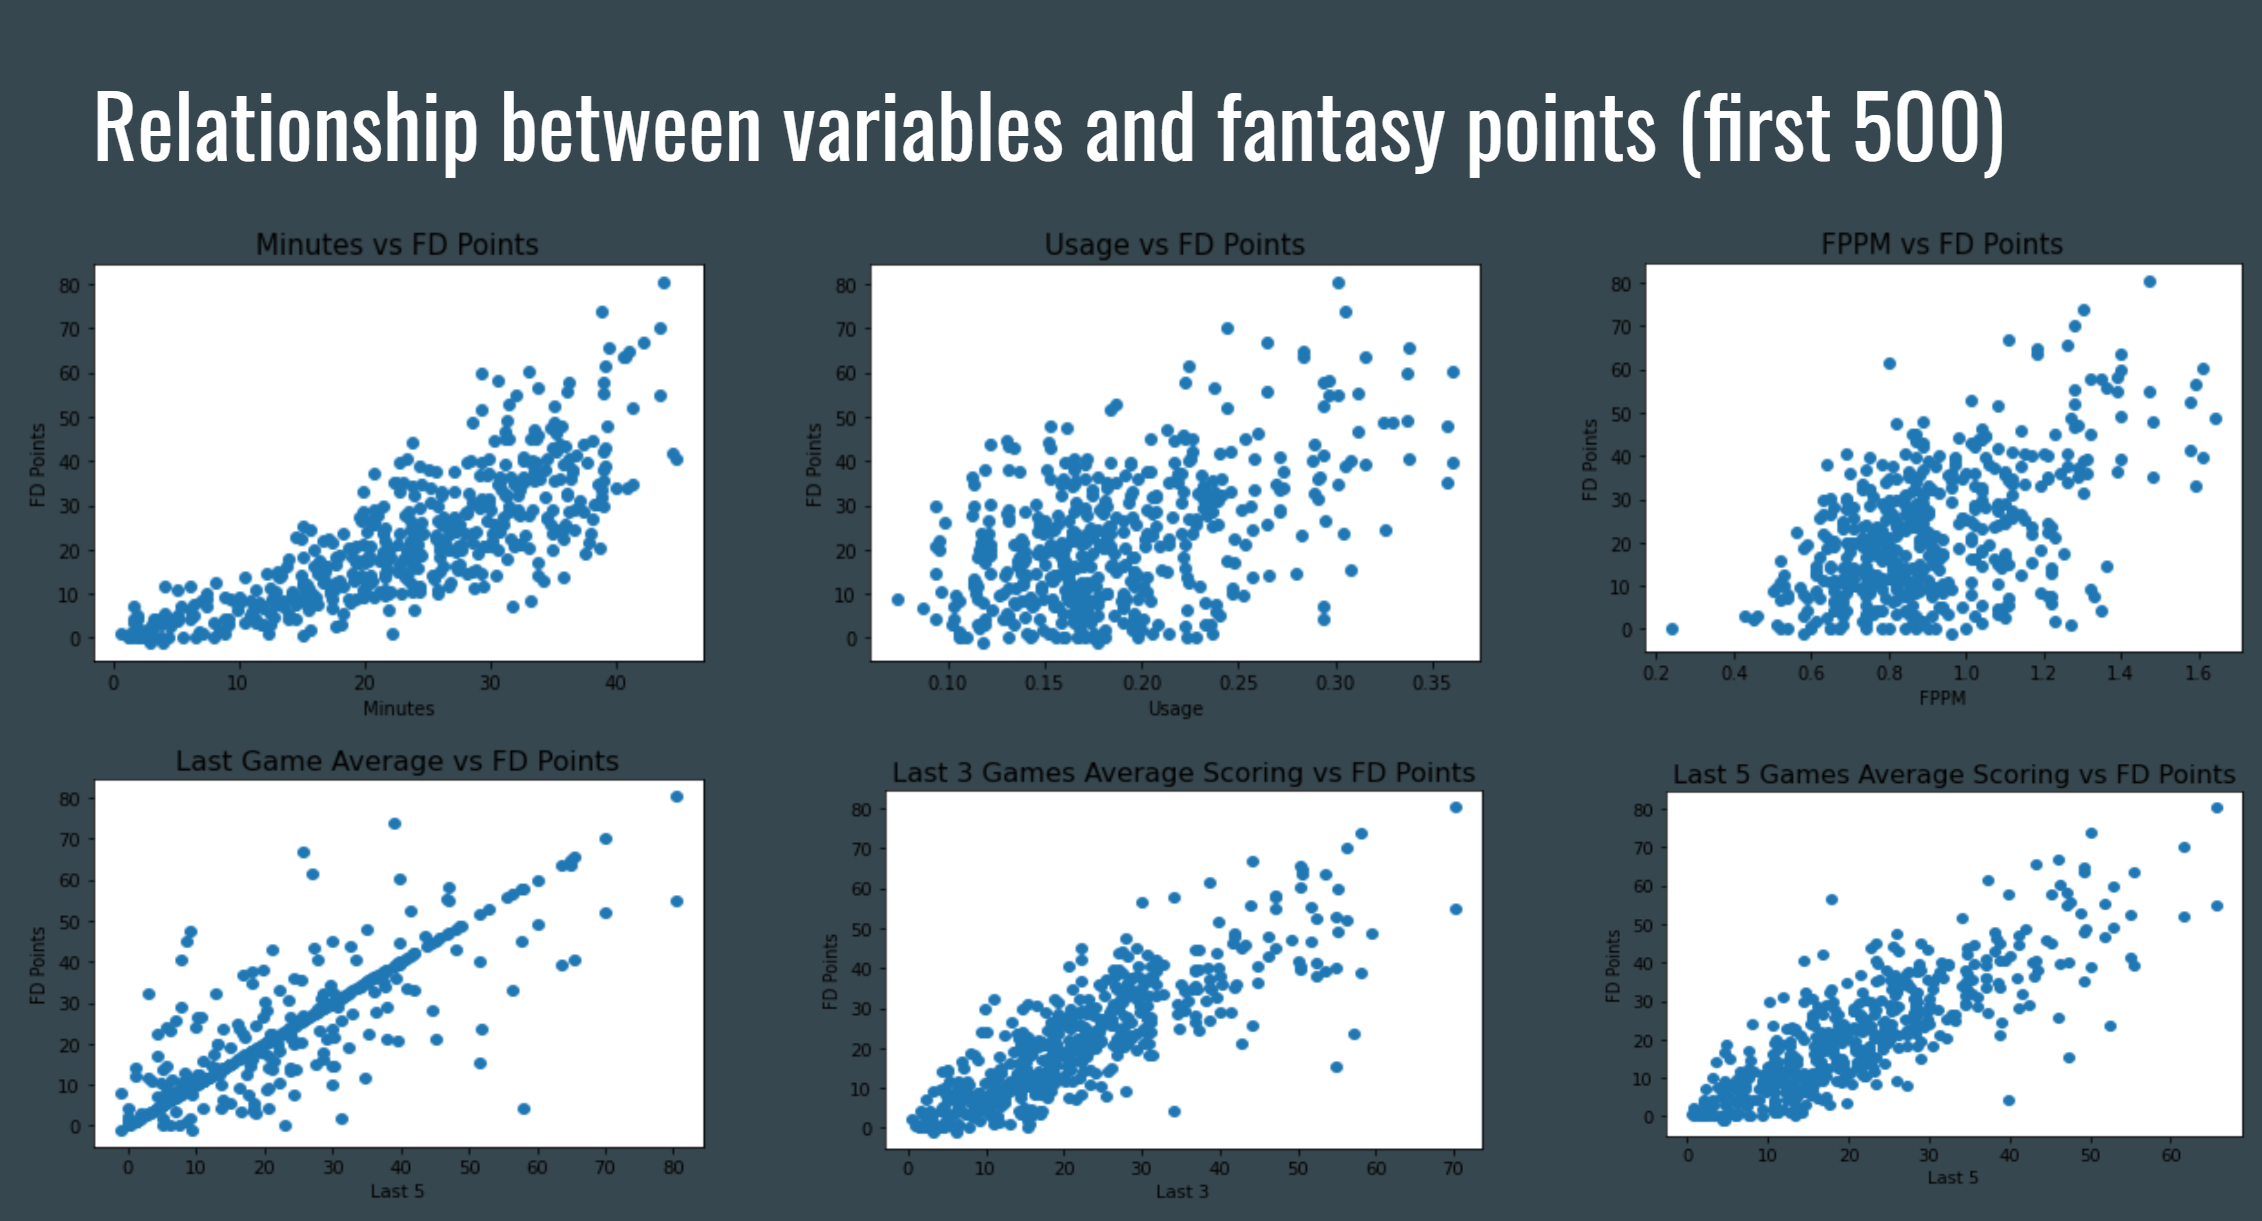

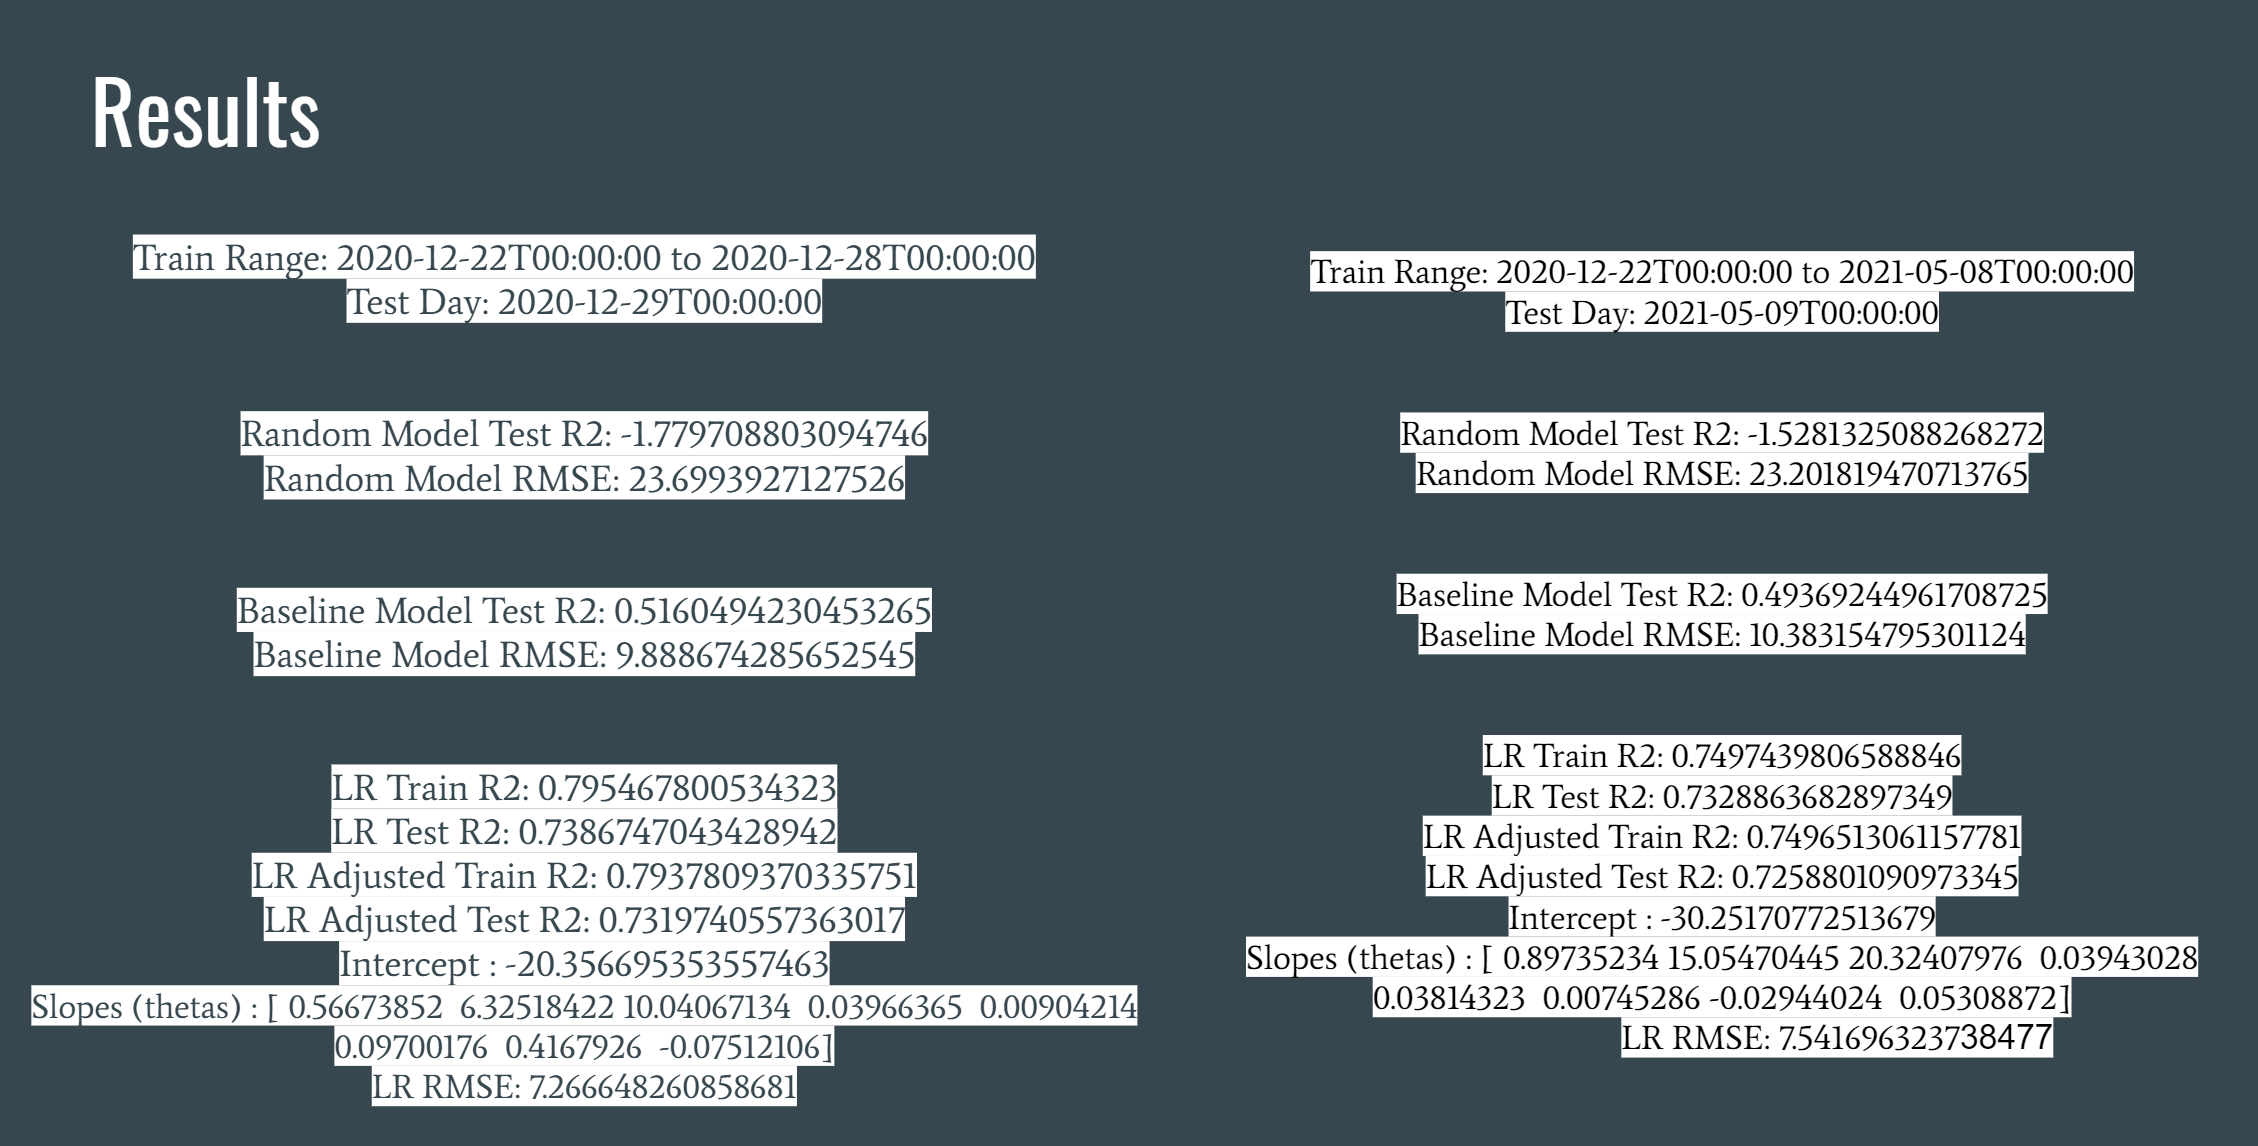

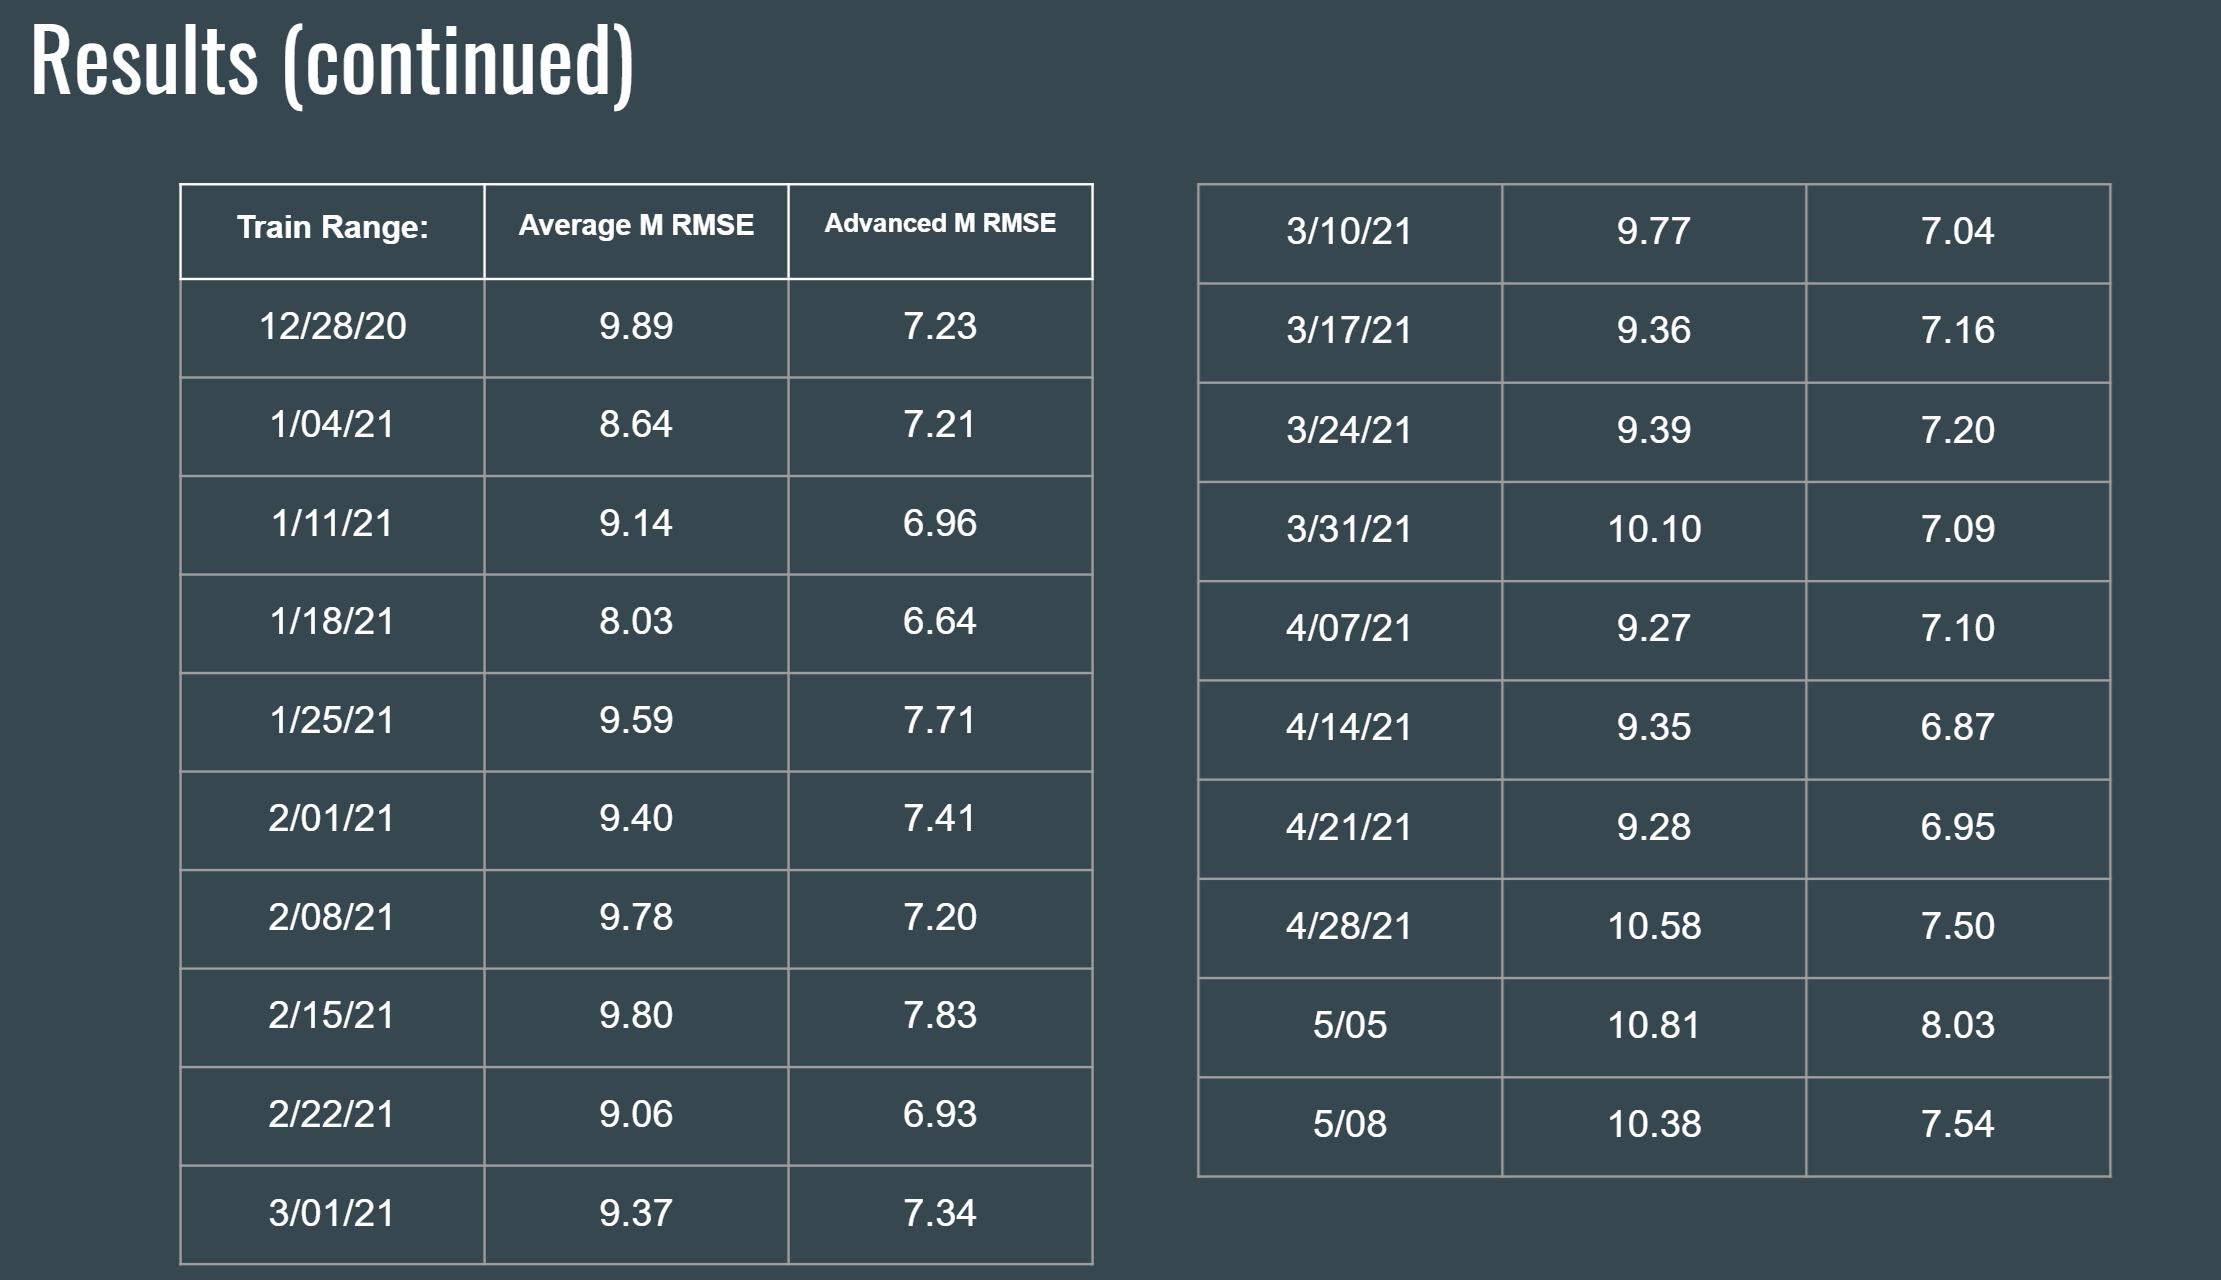


<div>

In [ ]:
def main():
    np.set_printoptions(suppress=True)
    pd.set_option('display.max_columns', None)
    
    #import sheet with player info for today (salary, name, etc.)
    todays_file = r"C:\Users\cobio\OneDrive\Desktop\Senior Project\FD-NBA-5-10-21.csv"
    player_info = getPlayerInfo(todays_file)
    
    #get IDs of the games happening on current date
    final_game_IDs = getGamesToday()
    time.sleep(10)
    
    #get players playing on current date (injured players included)
    players = getPlayersToday(final_game_IDs)
    time.sleep(10)
    
    #IDs of those players today
    players_IDs_today = players[0]
    
    #names of those players today
    players_names_today = players[1]
    
    #dictionary with key of player name, value of their projected minutes
    player_proj_min_dict = setProjectedMinutes(players_names_today, player_info)
    
    #players names in list format (ordered differently from players_names_today for training)
    players_names = list(player_proj_min_dict.keys())
    
    #players minutes in list format from dictionary for training
    player_proj_min = list(player_proj_min_dict.values())
    player_proj_min = np.array(player_proj_min)
    
    train_model = trainingSeason()
    linear_regression = train_model[0]
    player_usage = train_model[1]
    player_fppm = train_model[2]

    #get the players playing today's usage, fppm, implied total, spread (the variables)
    todays_usage_vector = []
    todays_fppm_vector = []
    todays_implied_total_vector = []
    todays_spread_vector = []
    temp_implied_total = getImpliedTeamTotals(player_info)
    temp_spread = getGameSpread(player_info)
    for i in players_names:
        todays_usage_vector.append(player_usage[i])
        todays_fppm_vector.append(player_fppm[i])
        todays_implied_total_vector.append(temp_implied_total[i])
        todays_spread_vector.append(temp_spread[i])

        
    #get player game logs for this season
    all_logs = playergamelogs.PlayerGameLogs(season_nullable = '2020-21')
    game_logs = all_logs.player_game_logs.get_data_frame()
    recent_averages = getRecentPerformances(game_logs, players_names)
    last_game = recent_averages[0]
    last_3 = recent_averages[1]
    last_5 = recent_averages[2]
    
    #combine minutes, usage, fppm, total, spread, last game averages of players today into matrix for predictions
    X_values = np.column_stack((player_proj_min, todays_usage_vector, todays_fppm_vector, todays_implied_total_vector, todays_spread_vector, last_game, last_3, last_5))
    

    #make predictions based on thetas from linear model with the players playing today 
    prediction = predict(linear_regression[1], X_values, linear_regression[0])
    
    
    #map of players name to predicted points to be used in exporting the sheet
    player_proj_pts = {}
    count = 0
    for i in prediction:
        player_proj_pts[players_names[count]] = i
        count += 1
        
    #get the predicted value of each player (predicted points/salary)
    value = getValue(player_proj_pts, player_info)
    #export sheet of values obtained
    exportValueSheet(value, player_proj_min_dict, player_proj_pts, player_info)
    
    #change to match today's created file
    csv_file = r"C:\Users\cobio\OneDrive\Desktop\Senior Project\2021-05-10-NBA-value.csv"
   

    #set up a new dataset to run optimizer on based on today's created file
    if (len(sys.argv) < 2):
        print('Usage:', sys.executable, sys.argv[0], csv_file)
        sys.exit(1)

    players = [[], [], [], [], []]
    with open(csv_file, 'r', newline='') as file:
        reader = csv.DictReader(file)
      
        for row in reader:
            players[getPositionNumber(row['Position'])].append(
                [row['Name'], float(row['Projected Points']), int(float(row['Salary']))])
                            
    #create optimized lineup based on my projections
    lineupOptimizer(players)
        
    

    
    
main()


<br> <br>

<div class="alert alert-block alert-success">
    
<h2 align="center">Conclusion</h2> <br> <br>

<img align="right" src="sportsverse.png" width="150" height="200"/>

- As expected, the variables used in the model had a significant effect on the overall accuracy of being able to predict NBA fantasy scores. The advanced model did significantly better than the random model, and was approximately <br>
20-25% better than the average model in terms of root means squared error. 


- I plan on using this project to help me with building NBA fantasy lineups. 


- Since this is a big passion of mine, I will continue to try to improve the model by adding more variables, and by trying different machine learning algorithms other than linear regression.


- Hopefully, I will find that this projection model is accurate enough to be used by others, in which case, I will encorporate it into a feature for my website, https://www.sportsverse.org/. 

</div>
  
    